<div id="colab_button">
  <h1>Quick tour</h1>
  <a target="_blank" href="https://colab.research.google.com/github/mithril-security/blindbox/blob/main/docs/docs/getting-started/quick-tour.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>
______________________________

## Introduction
______________________________


**BlindBox**'s goal is to protect SaaS end users' data, by helping SaaS vendors deploy their applications in **hardware-based highly-isolated environments**. We also provide an additional customizable layer of isolation to help put the end user back in control of their data.

In practice, SaaS deployment with BlindBox is done in three steps:
1. Saas vendor prepares their application image
2. SaaS vendor sets up their BlindBox
3. Saas vendor deploys their application using BlindBox

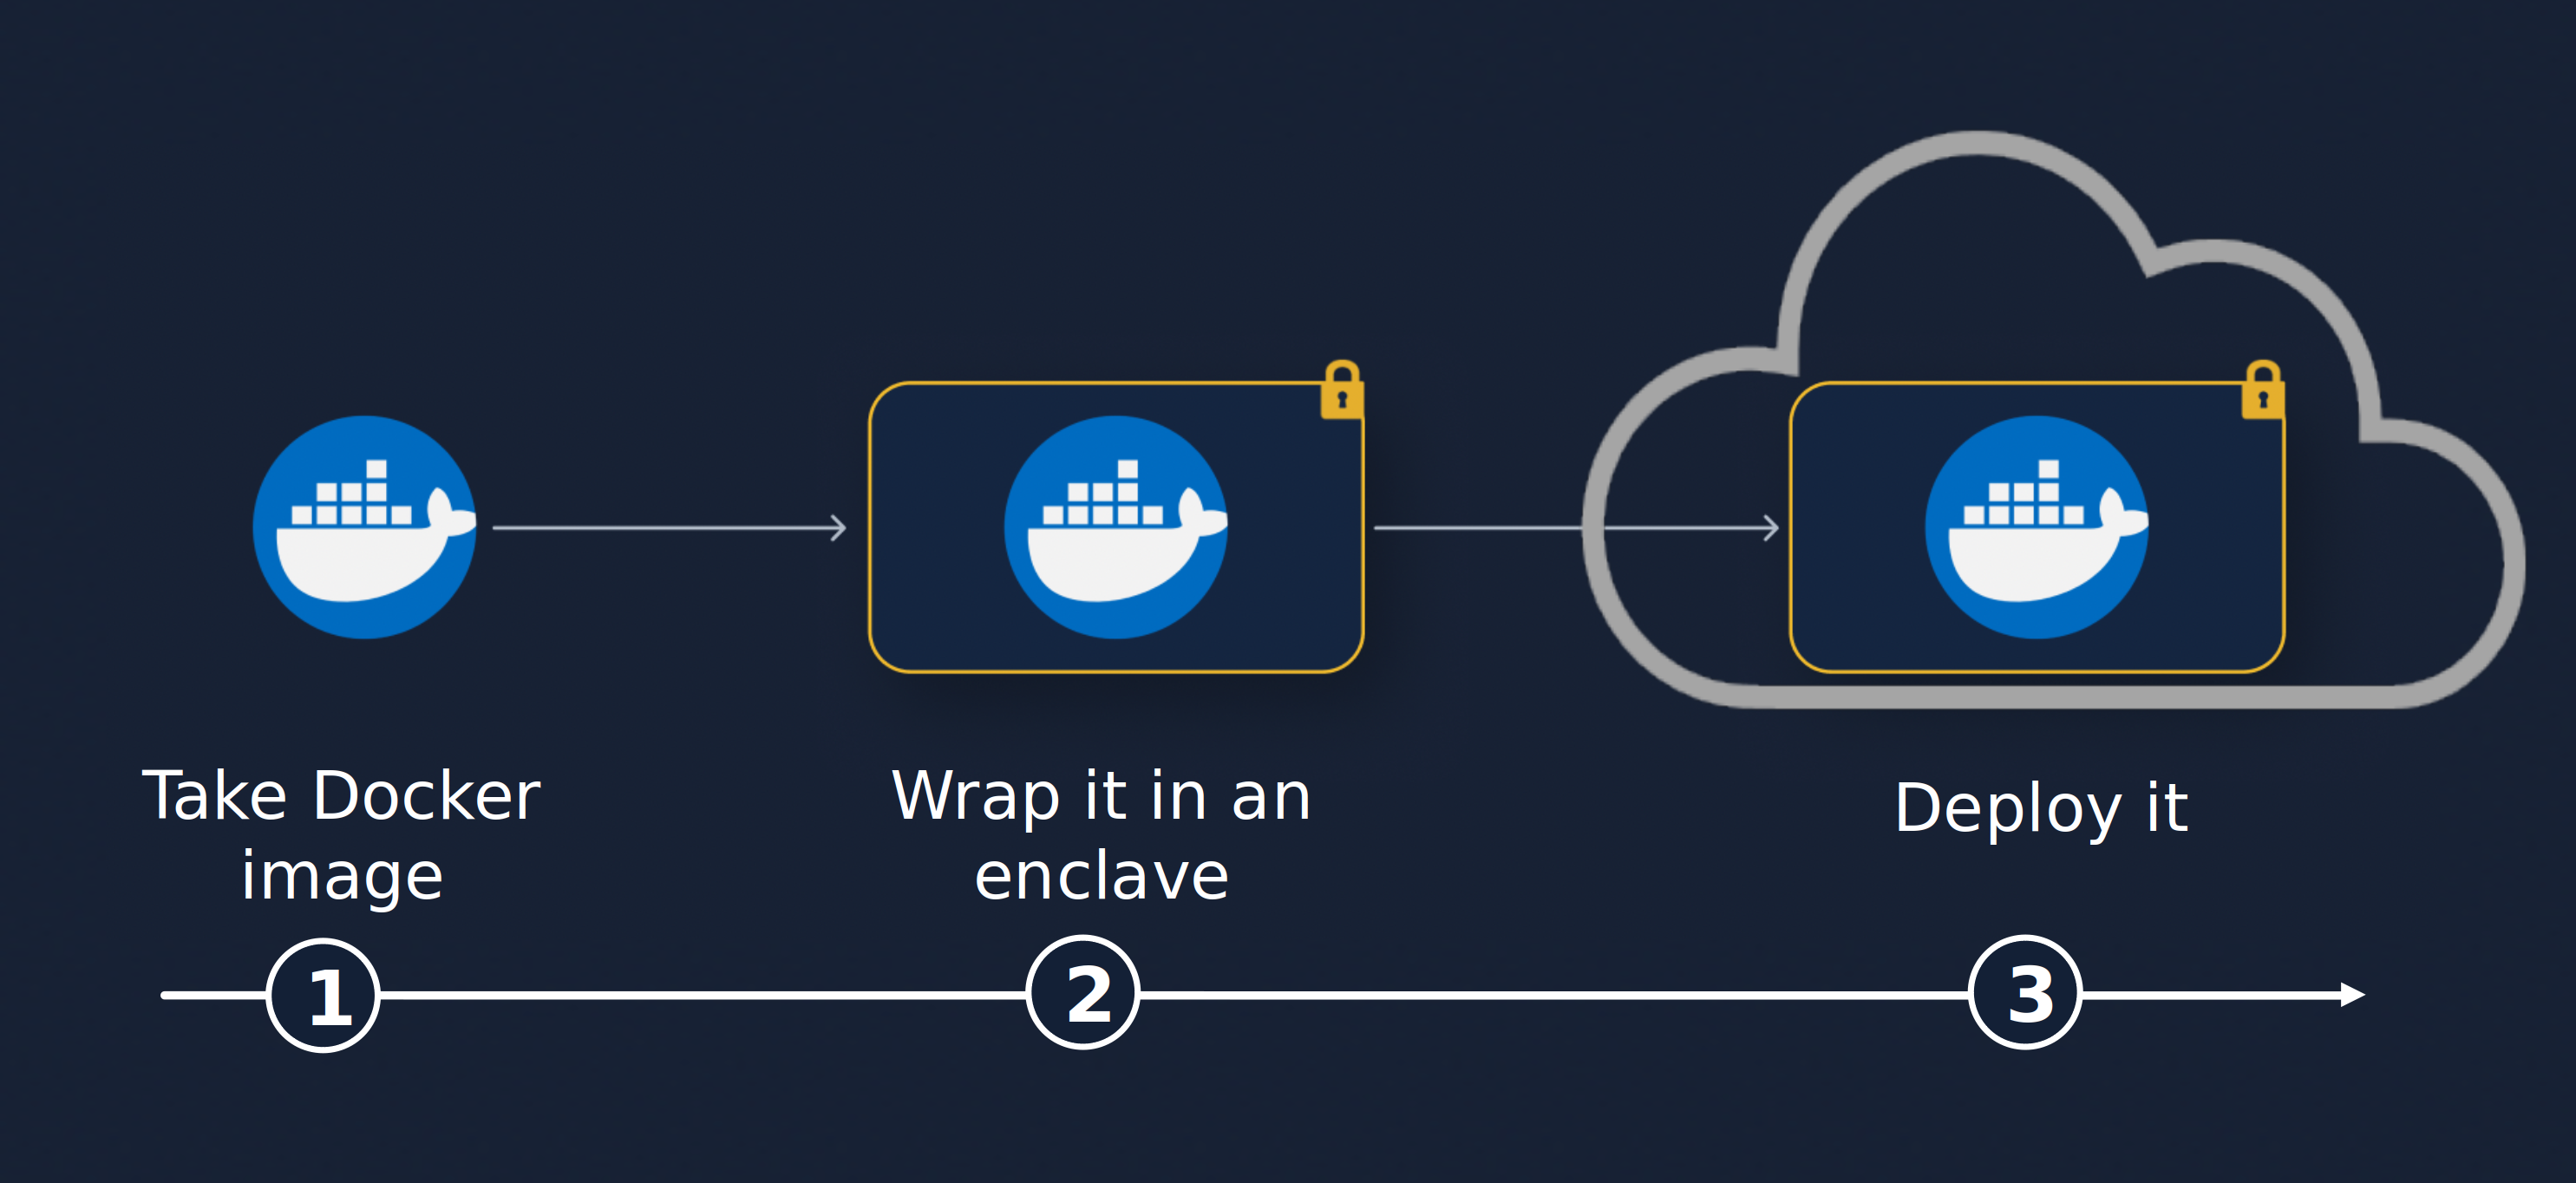

Once the application is deployed, end users can query the application with stringent privacy guarantees.

## Quick start guide
______________________

Let's take a lot at each of these steps using an example:

To do this, we'll step into the shoes of a Saas vendor deploying the OpenAI Whisper model with BlindBox so that their clients can query the model without exposing their data to the vendor.

To follow along with this guide and deploy your own BlindBox, you will need an **Azure account** and **credits**.

> Important: Our quick tour involves deploys a Whisper app on a DCasv5/ECasv5 series confidential VM with Azure. If you follow along with the quick-tour, you will be charged according to your usage as detailed by Azure. You can get a detailed pricing quote [here](https://learn.microsoft.com/en-us/azure/confidential-computing/confidential-vm-overview).

### Pre-requisites

For this code example to work, we will need to have Docker installed in your environment. 

If you are following along and don't have Docker already installed, you will need to install Docker, which you can do using the [following duie](https://docs.docker.com/desktop/install/linux-install/).

First of all, we need to install the [blindbox](https://pypi.org/project/blindbox/) Python library and `terraform`, which will facilitate the deployment of our BlindBox on our Azure confidential VM.

In [ ]:
# install blindbox
!pip install blindbox

# Install terraform
!wget -O- https://apt.releases.hashicorp.com/gpg | sudo gpg --dearmor -o /usr/share/keyrings/hashicorp-archive-keyring.gpg
!echo "deb [signed-by=/usr/share/keyrings/hashicorp-archive-keyring.gpg] https://apt.releases.hashicorp.com $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/hashicorp.list
!sudo apt update && sudo apt install terraform

We will also need to download the Azure CLI tool and log in to our Azure account.

In [ ]:
# Install azure-cli
!curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash

# Install confcom extension for azure-cli
!az extension add -n confcom

# Log in using azure-cli
!az login

# Set the subscription azure-cli will use by default.
!az account set --subscription "Microsoft Azure Sponsorship"

When running the `az login` command, you will be provided with a link that you will need to open in your browser to successfully login to your Azure account.

The final requirement is to install our [test audio file](https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav) which we will use to query our Whisper model. This one was provided by University of Illinois at Chicago  as part of their Computer Science 101 course.

In [ ]:
# Download our example audio file and save it as `taunt.wav`

!wget https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav -O taunt.wav

### Step one: Saas vendor prepares their application image

The only requirement for application images to be deployed with BlindBox is that they must expose port 80. This application image will be wrapped within an outer BlindBox image which is responsible for implementing customizable security policy and communicates with the inner image using this port.

> Currently we only support Docker images.

For this example, we provide a docker image for our example Whisper application within the `ai_server_example` folder of the BlindBox repository. You can view the Dockerfile for our application by downloading the BlindBox repo [here](https://github.com/mithril-security/blindbox).

In [ ]:
!git clone https://github.com/mithril-security/blindbox
!cd ai_server_example
!ls

We will build our application image ready to be deployed with BlindBox, giving it the `myimage` tag.

In [ ]:
!docker build -t myimage .

### Step two: SaaS vendor sets up their BlindBox

The next step is to initalize our blindbox. This step will create two template configuration files needed for our BlindBox, a `blindbox.tf` file and a `blindbox.yml` file, which users can modify.

+ The `blindbox.yml` file should be modified before building your blindbox. It has modifiable `platform` and `ip-rules` options, where you can specify the TEE type you want to use (we currently only support `amd-sev`) and the user `ip addresses` who are allowed to query the blindbox application.

+ The `blindbox.tf` file should be modified before deploying your blindbox. It changes the configuration of your confidential VM which we provision and deploy our BlindBox on.

To perform this initialization step, we run the following command:

In [ ]:
!blindbox init --env azure-sev

We specify that we want to use the AMD SEV TEE platform with Azure by using the `azure-sev` environment argument.

> Note this is the only platform currently supported. `aws-nitro` is **coming soon**.

### Step three: SaaS vendor builds BLindBox image

Next we are ready to build our BlindBox image.

> The BlindBox image is a wrapper around your application image which implements custom security policies.

We do this using `blindbox` build and specifying the application image using the `--source-image` option.

This will build the image and implement the configuration for this outer image as defined in the `blindbox.yml` file.

In [ ]:
# build the application image with our specified tag
!blindbox build -t myimage-blindbox:v1 --source-image myimage:v1

### Step four: Deploy BlindBox

To deploy our image within our secure enclave, we use the `deploy` command.

This will deploy our blindbox image (which contains the inner `application` image) on an Azure confidential VM. 

In [ ]:
# deploy our image inside confidental VM using BlindBox

!blindbox deploy

### Querying enclave

Our clients can now query the model within the enclave using the `blindbox.requests` module.

In [ ]:
from blindbox  import requests

# we query our application, sending it our audio file
res = requests.post(url="http://localhost:8080/enclave/predict", files={"audio": open("test.wav", "rb")})

# display result
print(res) 

### Next steps
 
Now that we've seen how deployment with BlindBox works, let's find out more about how BlindBox protects end users' data in the following [section](./confidential_computing.md).